In [2]:
import chess.pgn

In [3]:
pgn = open("../givenData/data/data.pgn")

In [4]:
first_game = chess.pgn.read_game(pgn)
first_game.headers

OrderedDict([('Event', '1'),
             ('Site', 'kaggle.com'),
             ('Date', '??'),
             ('Round', '??'),
             ('White', '??'),
             ('Black', '??'),
             ('Result', '1/2-1/2'),
             ('WhiteElo', '2354'),
             ('BlackElo', '2411')])

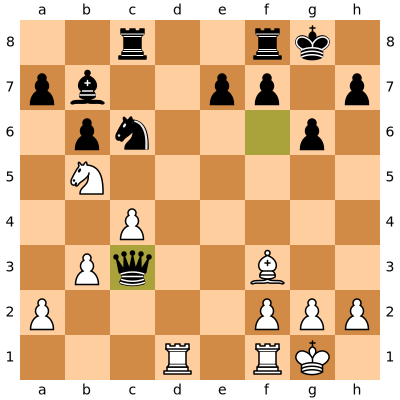

In [6]:
# Iterate through all moves and play them on a board.
board = first_game.board()
for move in first_game.main_line():
    board.push(move)
board

In [23]:
def get_games(filename="../givenData/data/data.pgn",
              n_games=50001):
    with open(filename) as pgn:
        game = chess.pgn.read_game(pgn)
        cnt = 0
        while game and cnt < n_games:
            cnt += 1
            yield game
            game = chess.pgn.read_game(pgn)
        #print(cnt)
games = [get_games()]

In [30]:
from sklearn.feature_extraction import DictVectorizer
from collections import defaultdict, Counter
import chess.pgn
import chess
from chess import QUEEN

In [31]:
def extract_game_features(game):
    """Extract features for a given game"""

    first_check = True
    first_queen_move = True

    features = defaultdict(int)
    node = game

    while node.variations:  # and node.board().fullmove_number < cut_off:
        move = node.variation(0).move

        board = node.board()

        # print(board.fullmove_number, move)
        moved_piece = board.piece_type_at(move.from_square)
        captured_piece = board.piece_type_at(move.to_square)

        if moved_piece == QUEEN and first_queen_move:
            features['queen_moved_at'] = board.fullmove_number
            first_queen_move = False

        if captured_piece == QUEEN:
            features['queen_changed_at'] = board.fullmove_number

        # if captured_piece:
            # print('Capture', board.fullmove_number, move, moved_piece,captured_piece)
            # captures[]
            # if board.fullmove_number == 10:
            #    features['captures_5']
        if move.promotion:
            features['promotion'] += 1
        if board.is_check():
            features['total_checks'] += 1
            if first_check:
                features['first_check_at'] = board.fullmove_number
                first_check = False
        # castling
        uci_repr = move.uci()
        if uci_repr == 'e1g1':
            features['white_king_castle'] = board.fullmove_number
        elif uci_repr == 'e1c1':
            features['white_queen_castle'] = board.fullmove_number
        elif uci_repr == 'e8g8':
            features['black_king_castle'] = board.fullmove_number
        elif uci_repr == 'e8c8':
            features['black_queen_castle'] = board.fullmove_number

        node = node.variation(0)
    if board.is_checkmate():
        features['is_checkmate'] += 1
    if board.is_stalemate():
        features['is_stalemate'] += 1
    if board.is_insufficient_material():
        features['insufficient_material'] += 1
    if board.can_claim_draw():
        features['can_claim_draw'] += 1
    features['total_moves'] = board.fullmove_number

    # Pieces at the end of the game
    piece_placement = board.fen().split()[0]
    end_pieces = Counter(x for x in piece_placement if x.isalpha())

    # count number of piece at end position
    features.update({'end_' + piece: cnt
                     for piece, cnt in end_pieces.items()})
    return features

In [129]:
def games_features():
    l = []
    pgn = open("../givenData/data/data.pgn")
    game = chess.pgn.read_game(pgn)
    cnt = 0
    elos = []
    results = []
    resultFeature = {}
    while game and cnt < 100:
        cnt += 1
        game = chess.pgn.read_game(pgn)
        features = extract_game_features(game)
        result = game.headers['Result'].split("-")
        if (result[0] == '1/2'):
            result[0] = 0.5
            result[1] = 0.5
        else:
             result[0] = int(result[0])
             result[1] = int(result[1])
        features['WhiteResult'] = result[0]
        features['BlackResult']= result[1]
        results.append(resultFeature)
        l.append(features)
        elos.append(int(game.headers['WhiteElo']))
        elos.append(int(game.headers['BlackElo']))

    vec = DictVectorizer()
    X = vec.fit_transform(l)
    return X,elos,results, l,vec

X, elos, results, features, vec = games_features()

In [131]:
import numpy as np

stockfish = pd.read_csv('../givenData/stockfish/stockfish.csv')
stockfish.MoveScores = stockfish.MoveScores.str.replace('NA','').str.split()
stockfish.MoveScores = stockfish.MoveScores.apply(lambda x: np.asarray(x, dtype=int))
stockfish.drop('Event', axis=1, inplace=True)
#stockfish.index = list(range(0, 2*len(ecos),2))
stockfish.head()

,MoveScores
0,"[18, 17, 12, 8, -5, 12, 3, -2, 22, 21, 20, 13,..."
1,"[26, 44, 26, 18, 14, 34, 36, 31, 37, 35, 42, 5..."
2,"[26, 51, 68, 57, 65, 77, 48, 93, 61, 63, 63, 5..."
3,"[2, 21, 5, 53, 35, 45, 37, 54, 10, 22, 8, 48, ..."
4,"[26, 64, 35, 53, 18, 20, 18, 20, 10, 49, 60, 9..."


In [169]:
import pandas as pd
names=vec.get_feature_names()
games_array = pd.DataFrame(X.toarray(), columns=names)

In [184]:
def extract_score_features(scores):
    features = dict()
    if scores.size == 0:
        return features
    scores = np.r_[0, scores]
    abs_scores = np.abs(scores)
    diffs = np.diff(scores)
    white_diffs = diffs[::2]
    black_diffs = diffs[1::2]
    subset_names = ['diffs', 'white_diffs', 'black_diffs']
    subsets = [diffs, white_diffs, black_diffs]
    stats = [np.min, np.max, np.mean, lambda x: np.median(np.abs(x))]
    stat_names = ['min', 'max', 'mean', 'median_abs']
    for subset, subset_name in zip(subsets, subset_names):
        for stat, stat_name in zip(stats, stat_names):
            features[stat_name + '_' + subset_name] = stat(subset)
            # np.hi
    features['advantage120_idx'] = np.argmax(abs_scores > 120) or len(scores)
    features['advantage70_idx'] = np.argmax(abs_scores > 70) or len(scores)
    return features

In [188]:
l = stockfish.MoveScores.apply(extract_score_features).tolist()
vec = DictVectorizer()
X = vec.fit_transform(l)
scores_df = pd.DataFrame(X.toarray(), columns=vec.get_feature_names())

In [192]:
final_df = scores_df[:100].join(games_array)

In [84]:
elos = np.array(elos)
mean_elos = (elos[::2] + elos[1::2]) / 2
elo_difference = elos[::2] - elos[1::2]
mean_elos.shape, elo_difference.shape

((100,), (100,))

In [196]:
X_train, X_test = X[:75], X[75:]
mean_elo_train, mean_elo_test = mean_elos[:75], mean_elos[75:]
elo_diff_train, elo_diff_test = elo_difference[:75], elo_difference[75:]

In [198]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

In [199]:
rf_mean = RandomForestRegressor(n_estimators=500, n_jobs=-1)
rf_mean.fit(X_train, mean_elo_train)
mean_pred_rf = rf_mean.predict(X_train)
mean_absolute_error(mean_elo_train, mean_pred_rf)

66.596626666666666

In [200]:
rf_diff = RandomForestRegressor(n_estimators=500, n_jobs=-1)
rf_diff.fit(X_train, elo_diff_train)
elo_difference_pred = rf_diff.predict(X_train)
mean_absolute_error(elo_diff_train, elo_difference_pred)

77.008880000000005

In [201]:
mean_pred_rf = rf_mean.predict(X_test)
elo_difference_pred = rf_diff.predict(X_test)
white_elos = mean_pred_rf + elo_difference_pred / 2
black_elos = mean_pred_rf - elo_difference_pred / 2

In [209]:
real_white_elos = elos[::2]
real_black_elos = elos[1::2]
print(white_elos)
print(black_elos)
print(real_white_elos[75:100])
print(real_black_elos[75:100])

[ 2068.391  2157.436  2169.042 ...,  2220.694  2340.374  2131.98 ]
[ 2117.061  2210.25   2206.322 ...,  2153.424  2299.434  2227.846]
[2516, 2152, 2706, 2103, 1381, 2391, 2380, 2051, 1945, 2270, 2460, 2443, 2548, 2172, 2484, 2119, 2583, 2531, 2291, 2171, 1962, 2183, 2250, 2645, 1766]
[2706, 2255, 2713, 1870, 1735, 2431, 2192, 2185, 2171, 2152, 2329, 2407, 2475, 1880, 2507, 2199, 2461, 2552, 2459, 2040, 2061, 1931, 2680, 2522, 2053]


In [210]:
rf_mean.feature_importances_

array([ 0.12815531,  0.08831796,  0.06094841,  0.04695588,  0.09123078,
        0.09436524,  0.0803241 ,  0.1150443 ,  0.04117306,  0.03696422,
        0.06447995,  0.03638093,  0.05411244,  0.06154742])